In [14]:
import numpy as np
import h5py as h5

import tensorflow as tf

import matplotlib.pyplot as plt

In [15]:
### check n direction
### why different loss ?
### c in t_curv ???
### use real coords

In [16]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Read and prepare data

In [17]:
h5f = '../../mc_hadrons_qgs34_0010.h5'

In [18]:
num = 64

with h5.File(h5f,'r') as hf:
    times_flat = hf['pr-q4-9yr/dt'][:num,:,:,4:5]*1e6 # in mks
    times_diff = hf['pr-q4-9yr/dt'][:num,:,:,5:6]*1e6 # in mks
    mask = hf['pr-q4-9yr/dt'][:num,:,:,6:7]
    real_coords = hf['pr-q4-9yr/dt'][:num,:,:,:3] # in 1.2*km
    qs = hf['pr-q4-9yr/dt'][:num,:,:,3:4]
    ev_params = hf['pr-q3-9yr/ev_params'][:num]
    
times_reg = times_flat + times_diff
mask_qs = tf.where( tf.math.logical_and(mask>0, qs>0), 1., 0. )

In [19]:
xs = tf.expand_dims( tf.linspace( 0., 5*1.2, 6 ), axis=-1 )
xs = tf.repeat(xs, 6, axis=1)
ys = tf.transpose( xs )
coords = tf.expand_dims( tf.stack( (xs,ys), axis=-1 ), axis=0 ) # in km

In [20]:
c = tf.constant(0.299792458, dtype=tf.float32) # in km\mks

### Linear approximation

In [21]:
# prepare matricies to solve
def make_matrix(coords, times_reg, mask):
    
    # matrix for dL/db
    hs = tf.ones((1,6,6,1)) # to make (x_1,x_2) -> (x_1,x_2,1), to account for b
    coords_ext = mask*tf.concat( (coords,hs), axis=-1 ) # (bs,6,6,3)
    matrix_b = tf.expand_dims( tf.math.reduce_sum( coords_ext, axis=(1,2) ), axis=-1 ) # (bs,6,6,3,1)
    times = mask*times_reg # (bs,6,6,1)
    rhs_b = tf.math.reduce_sum( times, axis=(1,2) ) # (bs,1)
    
    # matrix for dL/da
    coords_mul = tf.expand_dims( coords_ext, axis=-1) * tf.expand_dims( coords, axis=-2)
    matrix_a = tf.math.reduce_sum( coords_mul, axis=(1,2) ) # (bs,6,6,3,2)
    ts_mul = times * coords
    rhs_a = tf.math.reduce_sum( ts_mul, axis=(1,2) )
    
    matrix = tf.concat((matrix_b,matrix_a), axis=-1)
    rhs = tf.expand_dims( tf.concat((rhs_b,rhs_a), axis=-1), axis=-1 )
    
    return matrix, rhs

In [27]:
def lin_solve(matrix, rhs):
    
    sol_flat = tf.linalg.solve( matrix, rhs, adjoint=True )[:,:,0]
#     print(sol_flat)
    t0 = sol_flat[:,2]
    # extract parameters
    n_z = 1/c/c - tf.math.reduce_sum(sol_flat[:,:2]*sol_flat[:,:2], axis=1)
    n_z = tf.where( n_z>0, tf.math.sqrt( n_z ), 0. ) # some configurations yield front moving faster than light
    theta_flat = tf.math.acos( n_z*c )
    phi_flat = tf.math.atan2( sol_flat[:,1], sol_flat[:,0] )
    
    return theta_flat, phi_flat, t0

In [28]:
matrix, rhs = make_matrix(coords, times_reg, mask)
theta, phi, t0 = lin_solve(matrix, rhs) # (bs,)

In [35]:
phi/3.14*180

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([ -45.090675 ,   59.493122 , -151.83202  ,  -66.795746 ,
        -40.908295 ,  109.61158  ,   25.507902 , -159.16087  ,
        -66.04494  , -117.72843  , -142.08736  ,  -64.07822  ,
         38.190773 ,  -72.61241  , -152.02588  ,  114.31395  ,
       -130.48126  ,  179.37828  ,  114.47934  ,   66.028435 ,
        -71.42547  ,  148.41838  ,  147.47336  ,  111.154564 ,
         99.09006  ,  111.39848  ,  -38.16081  , -173.6324   ,
        152.98344  ,   44.788975 ,  -45.31987  ,  -15.201984 ,
        138.35306  , -160.82552  ,   20.068356 ,  -95.30713  ,
         71.44137  , -154.94284  ,  107.48643  ,   48.002686 ,
          4.0393744,  -55.981457 ,  133.64186  , -174.19273  ,
         71.1309   ,  130.7888   ,  116.42755  ,  -37.481594 ,
         11.4989195,   85.55882  ,    1.0422605,  138.42151  ,
         57.84859  , -141.22237  ,   13.51256  ,  -13.543718 ,
       -105.87633  ,  178.18668  , -165.66962  ,  -29.445803 ,
        

#### Check

In [46]:
t0_ext = t0[:,tf.newaxis,tf.newaxis]
nx = 1/c*tf.math.sin(theta)[:,tf.newaxis,tf.newaxis] * tf.math.cos(phi)[:,tf.newaxis,tf.newaxis]
ny = 1/c*tf.math.sin(theta)[:,tf.newaxis,tf.newaxis] * tf.math.sin(phi)[:,tf.newaxis,tf.newaxis]
a = tf.concat((nx,ny), axis=-1)
a = tf.expand_dims( a, axis=1 )
print(a)
t_rec = t0_ext + tf.math.reduce_sum( a*coords, axis=-1 )
t_rec = t_rec*mask[:,:,:,0]

tf.Tensor(
[[[[ 1.6905677  -1.6945747 ]]]


 [[[ 0.99044377  1.6789573 ]]]


 [[[-2.192621   -1.1778891 ]]]


 [[[ 0.6644186  -1.5473607 ]]]


 [[[ 1.5665903  -1.3564276 ]]]


 [[[-0.5063862   1.4255593 ]]]


 [[[ 1.693558    0.80760324]]]


 [[[-1.1613623  -0.44394135]]]


 [[[ 0.53928494 -1.2119058 ]]]


 [[[-0.36687472 -0.6997204 ]]]


 [[[-0.89717627 -0.70056456]]]


 [[[ 0.8620558  -1.771063  ]]]


 [[[ 1.4865383   1.1685897 ]]]


 [[[ 0.44323626 -1.4122608 ]]]


 [[[-1.2110289  -0.6453039 ]]]


 [[[-0.47500023  1.0541668 ]]]


 [[[-1.1263392  -1.3227371 ]]]


 [[[-1.9163818   0.02383713]]]


 [[[-0.8919313   1.9643096 ]]]


 [[[ 0.8607138   1.9327378 ]]]


 [[[ 0.58633137 -1.7411686 ]]]


 [[[-1.4055796   0.86664224]]]


 [[[-1.5946548   1.0198793 ]]]


 [[[-0.32000068  0.829378  ]]]


 [[[-0.15180498  0.9541658 ]]]


 [[[-0.6235392   1.5958369 ]]]


 [[[ 1.142453   -0.89713335]]]


 [[[-1.4398547  -0.16292098]]]


 [[[-0.8031075   0.4108667 ]]]


 [[[ 1.1281954   1.1190281 ]]]



In [47]:
t_rec

<tf.Tensor: shape=(64, 6, 6), dtype=float32, numpy=
array([[[-0.        , -0.        , -0.        , -0.        ,
         -0.        , -0.        ],
        [ 0.        , -0.        , -0.        , -0.        ,
         -0.        , -0.        ],
        [ 0.        ,  0.        , -0.        , -3.1249223 ,
         -5.158412  , -0.        ],
        [ 0.        ,  0.        ,  0.9372493 , -1.0962404 ,
         -3.1297302 , -0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.9324404 ,
         -0.        , -0.        ],
        [ 0.        ,  0.        ,  4.994611  ,  0.        ,
          0.        , -0.        ]],

       [[-0.        , -0.        , -0.        , -0.        ,
         -0.        ,  0.        ],
        [-0.        , -0.        , -0.        , -0.        ,
         -0.        ,  0.        ],
        [-0.        , -0.        , -0.        , -0.9901104 ,
          0.        ,  0.        ],
        [-0.        , -0.        , -1.8163271 ,  0.19842148,
          2.

In [44]:
t_rec[1]

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       ,  8.421312 ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  7.5950956,  9.609844 , 11.624593 ,
         0.       ],
       [ 0.       ,  0.       ,  8.783628 , 10.798377 , 12.813126 ,
         0.       ],
       [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ]], dtype=float32)>

In [42]:
t0_ext

<tf.Tensor: shape=(64, 1, 1), dtype=float32, numpy=
array([[[ -1.0818156 ]],

       [[ -9.411423  ]],

       [[ 12.180873  ]],

       [[  3.3125598 ]],

       [[ -2.033852  ]],

       [[ -5.9170237 ]],

       [[ -7.2979884 ]],

       [[  7.119641  ]],

       [[  2.6467204 ]],

       [[  4.3824077 ]],

       [[  6.763143  ]],

       [[  4.004331  ]],

       [[ -8.332845  ]],

       [[  5.4817886 ]],

       [[  9.464282  ]],

       [[ -1.446     ]],

       [[  9.62021   ]],

       [[  8.648997  ]],

       [[ -1.9128022 ]],

       [[ -7.716711  ]],

       [[  4.4970164 ]],

       [[  3.4287083 ]],

       [[  2.3299828 ]],

       [[ -1.0217546 ]],

       [[ -1.8223338 ]],

       [[ -2.5787718 ]],

       [[ -1.0533029 ]],

       [[  7.211702  ]],

       [[  2.7141802 ]],

       [[ -8.1832905 ]],

       [[  4.0757537 ]],

       [[ -3.485143  ]],

       [[  0.9643655 ]],

       [[  8.388334  ]],

       [[ -9.509887  ]],

       [[  6.1425695 ]],

       [[ -8

In [32]:
t_rec

<tf.Tensor: shape=(64, 6, 6), dtype=float32, numpy=
array([[[-0.        , -0.        , -0.        , -0.        ,
         -0.        , -0.        ],
        [ 0.        , -0.        , -0.        , -0.        ,
         -0.        , -0.        ],
        [ 0.        ,  0.        , -0.        , -3.1249223 ,
         -5.158412  , -0.        ],
        [ 0.        ,  0.        ,  0.9372493 , -1.0962404 ,
         -3.1297302 , -0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.9324404 ,
         -0.        , -0.        ],
        [ 0.        ,  0.        ,  4.994611  ,  0.        ,
          0.        , -0.        ]],

       [[-0.        , -0.        , -0.        , -0.        ,
         -0.        ,  0.        ],
        [-0.        , -0.        , -0.        , -0.        ,
         -0.        ,  0.        ],
        [-0.        , -0.        , -0.        , -0.9901104 ,
          0.        ,  0.        ],
        [-0.        , -0.        , -1.8163271 ,  0.19842148,
          2.

In [33]:
diff = times_reg[:,:,:,0]*mask[:,:,:,0]-t_rec
print(tf.reduce_sum(diff, axis=(1,2)))

tf.Tensor(
[ 4.5895576e-06 -1.7285347e-05  2.8610229e-06 -3.3378601e-06
 -1.0728836e-06 -1.1205673e-05 -5.9604645e-08 -2.1815300e-05
  2.3841858e-07  1.4305115e-05 -1.6450882e-05  5.3644180e-06
 -8.9704990e-06  9.5367432e-07 -8.5830688e-06  2.4437904e-06
  1.0550022e-05 -7.9870224e-06  2.9802322e-07 -6.0200691e-06
 -8.2850456e-06  4.2915344e-06  7.1525574e-07 -2.4914742e-05
  1.3589859e-05  6.6161156e-06  2.9802322e-06 -1.9073486e-06
  1.3113022e-05 -3.5762787e-07  4.7683716e-07 -8.3446503e-06
 -1.1920929e-06  1.1086464e-05  8.1062317e-06 -3.2186508e-06
 -3.3378601e-06 -8.7022781e-06  3.9339066e-06 -1.1205673e-05
  8.1062317e-06  4.5299530e-06 -8.8810921e-06 -2.5749207e-05
  3.8862228e-05 -2.2649765e-06  1.4901161e-07 -4.7683716e-07
  5.3048134e-06  3.7550926e-06  2.5111113e+00 -6.7961707e+00
 -8.4638596e-06 -8.3446503e-07 -4.7683716e-06 -1.5318394e-05
 -6.7353249e-06 -1.9073486e-06 -1.2397766e-05  3.4570694e-06
  1.4305115e-06 -1.7583370e-06  1.9073486e-05 -7.1525574e-06], shape=(64,)

### Shower core, initial

In [55]:
q_max = np.amax(qs)*1.1

In [56]:
def get_r_core_sat(qs, coords, mask, mask_qs, fill_val):
    
    qs = tf.where( mask==mask_qs, qs, [fill_val] )
    return tf.math.reduce_sum( qs*coords, axis=(1,2), keepdims=True ) / tf.math.reduce_sum(qs, axis=(1,2), keepdims=True)
      
def get_r_core(qs, coords):
    return tf.math.reduce_sum( qs*coords, axis=(1,2), keepdims=True ) / tf.math.reduce_sum(qs, axis=(1,2), keepdims=True)

In [57]:
r_core_sat = get_r_core_sat(qs, coords, mask, mask_qs, q_max) # (bs,1,1,2)
r_core = get_r_core(qs, coords)

In [58]:
print((r_core-r_core_sat)[:3,0,0,:]) # small difference since saturated detectors are near the center

tf.Tensor(
[[0.         0.        ]
 [0.24556708 0.10139894]
 [0.         0.        ]], shape=(3, 2), dtype=float32)


### S_800 reco

In [59]:
def get_eta(theta):
    
    x = theta*180.0/3.1415
    
    e1 = 3.97 - 1.79*(tf.math.abs(1.0/tf.math.cos(theta)+1e-6) - 1.0)
    e2 = ((((((-1.71299934e-10*x + 4.23849411e-08)*x -3.76192000e-06)*x
               + 1.35747298e-04)*x -2.18241567e-03)*x + 1.18960682e-02)*x
             + 3.70692527e+00)
    res = tf.where(x<62.7,e1,e2)
    
    return res

In [60]:
Rm = tf.constant([0.09])
R1 = tf.constant([1.])

def get_profile(r, eta):

    res = tf.math.pow(((r+1e-6)/Rm),-1.2) * tf.math.pow((1+r/Rm), -(eta-1.2)) * tf.math.pow(1.+(tf.math.pow(r,2)/R1/R1),-0.6)
    return res

In [61]:
R_x = tf.constant([[0.8]])

# r should be centered at shower's core
# normed so that ldf(800m)=1
def get_normed_ldf(r, theta):

    eta = get_eta(theta) # (batch,1,1)
    
    norm = get_profile(R_x, eta)
    ldf = get_profile(r, eta)
    
    return ldf/norm

In [62]:
s_min = tf.constant([[0.3]])
s_max = tf.constant([[1.8]])

def get_S_norm_raw(qs, coords, r_core, theta, phi, mask):
    # calculate distance to shower core
    cent_coords = coords - r_core
    proj_to_n = tf.math.sin(theta)*( tf.math.cos(phi)*cent_coords[:,:,:,0] + tf.math.sin(phi)*cent_coords[:,:,:,1] )
    dist_core = tf.math.sqrt( tf.math.reduce_sum( tf.math.pow(cent_coords,2), axis=(3) ) - tf.math.pow(proj_to_n,2) )
    # mask for distances
    mask_dist = tf.where( tf.math.logical_and(dist_core>s_min,dist_core<s_max), 1., 0. )
    mask = mask[:,:,:,0]*mask_dist
    
    mq = get_measured_ldf(mask, qs)
    eq = get_expected_ldf(dist_core, theta, mask)
    
    return mq, eq

def get_measured_ldf(mask, qs):

    return tf.math.reduce_sum( qs*mask, axis=(1,2) )

def get_expected_ldf(dist_core, theta, mask):
    print(dist_core, theta, mask)
    exp_qs = get_normed_ldf(dist_core, theta)*mask
    return tf.math.reduce_sum( exp_qs, axis=(1,2) )

In [63]:
# cent_coords = coords - r_core
print(coords-r_core)

tf.Tensor(
[[[[-3.7915704  -3.2109776 ]
   [-3.7915704  -2.0109775 ]
   [-3.7915704  -0.81097746]
   [-3.7915704   0.3890226 ]
   [-3.7915704   1.5890226 ]
   [-3.7915704   2.7890224 ]]

  [[-2.5915704  -3.2109776 ]
   [-2.5915704  -2.0109775 ]
   [-2.5915704  -0.81097746]
   [-2.5915704   0.3890226 ]
   [-2.5915704   1.5890226 ]
   [-2.5915704   2.7890224 ]]

  [[-1.3915703  -3.2109776 ]
   [-1.3915703  -2.0109775 ]
   [-1.3915703  -0.81097746]
   [-1.3915703   0.3890226 ]
   [-1.3915703   1.5890226 ]
   [-1.3915703   2.7890224 ]]

  [[-0.19157028 -3.2109776 ]
   [-0.19157028 -2.0109775 ]
   [-0.19157028 -0.81097746]
   [-0.19157028  0.3890226 ]
   [-0.19157028  1.5890226 ]
   [-0.19157028  2.7890224 ]]

  [[ 1.0084298  -3.2109776 ]
   [ 1.0084298  -2.0109775 ]
   [ 1.0084298  -0.81097746]
   [ 1.0084298   0.3890226 ]
   [ 1.0084298   1.5890226 ]
   [ 1.0084298   2.7890224 ]]

  [[ 2.2084296  -3.2109776 ]
   [ 2.2084296  -2.0109775 ]
   [ 2.2084296  -0.81097746]
   [ 2.2084296   0.389

In [64]:
theta = theta[:,tf.newaxis, tf.newaxis]
phi = phi[:,tf.newaxis, tf.newaxis]
t0 = t0[:,tf.newaxis,tf.newaxis]

In [65]:
mq, eq = get_S_norm_raw(qs[:,:,:,0], coords, r_core, theta, phi, mask_qs)
S_norm = mq/eq

tf.Tensor(
[[[4.960046   4.1964264  3.5713656  3.167969   3.0747545  3.3179688 ]
  [4.1140766  3.2672765  2.5615     2.1410704  2.1780264  2.6533241 ]
  [3.3748229  2.424959   1.5837102  1.128081   1.4743508  2.2828856 ]
  [2.8272698  1.7961015  0.77150536 0.31808186 1.3205479  2.3501556 ]
  [2.5957096  1.6467425  0.9069337  1.0344138  1.8585504  2.8240259 ]
  [2.760831   2.0827312  1.7860745  2.044278   2.702739   3.54503   ]]

 [[4.452565   3.9533699  3.6855514  3.6997018  3.992825   4.5108604 ]
  [3.73552    3.054092   2.6174803  2.554462   2.8895855  3.510624  ]
  [3.2724557  2.3773732  1.6568632  1.4102621  1.8392483  2.631954  ]
  [3.1764607  2.1453233  1.1248428  0.2801498  1.0208077  2.0386183 ]
  [3.478063   2.4857593  1.5528778  0.8911851  1.1521046  2.0027058 ]
  [4.090235   3.2220595  2.4866982  2.0337203  2.0588157  2.5478966 ]]

 [[3.7736764  2.877185   2.1992338  1.9788747  2.3486457  3.104385  ]
  [3.6883836  2.640688   1.69209    1.1287085  1.4851512  2.378706  ]
  [3.

In [67]:
eq

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([20.266956  ,  1.7238445 ,  7.6324205 ,  6.014812  ,  6.026663  ,
        1.1835656 ,  5.793085  ,  1.4008267 ,  1.2464347 ,  5.1736784 ,
       17.336102  ,  6.569727  ,  3.0956693 ,  1.1584668 ,  3.8953242 ,
        0.92226213,  6.3600283 ,  5.532247  ,  6.39348   ,  3.1695678 ,
        1.6590755 ,  2.910609  ,  5.727562  ,  0.9459435 ,  1.6301827 ,
        7.7452626 , 35.402065  ,  4.8803806 ,  0.89778376,  1.1443975 ,
        2.1316311 ,  1.9773852 ,  5.1140804 ,  6.672742  ,  5.4854794 ,
        6.9725037 ,  1.7945371 ,  6.829136  ,  5.417036  ,  1.0892943 ,
       19.82775   ,  6.937795  ,  3.9129481 ,  5.2385907 ,  0.92290133,
        6.799116  ,  7.320833  ,  1.6694509 ,  6.276173  ,  1.3207667 ,
        5.0167747 ,  4.233631  ,  3.9713821 ,  4.7146654 ,  4.8301907 ,
        1.0226961 ,  6.8906026 ,  5.934848  ,  1.3777804 ,  1.0533696 ,
        1.6752588 ,  2.330556  ,  5.052703  ,  7.0840917 ], dtype=float32)>

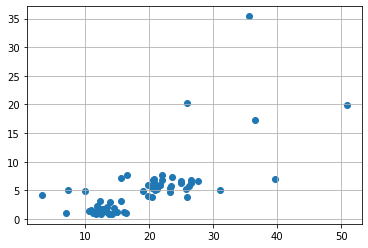

In [45]:
plt.scatter(mq,eq)
plt.grid(True)
#plt.ylim((0, 500))

In [46]:
coords

<tf.Tensor: shape=(1, 6, 6, 2), dtype=float32, numpy=
array([[[[0.       , 0.       ],
         [0.       , 1.2      ],
         [0.       , 2.4      ],
         [0.       , 3.6000001],
         [0.       , 4.8      ],
         [0.       , 6.       ]],

        [[1.2      , 0.       ],
         [1.2      , 1.2      ],
         [1.2      , 2.4      ],
         [1.2      , 3.6000001],
         [1.2      , 4.8      ],
         [1.2      , 6.       ]],

        [[2.4      , 0.       ],
         [2.4      , 1.2      ],
         [2.4      , 2.4      ],
         [2.4      , 3.6000001],
         [2.4      , 4.8      ],
         [2.4      , 6.       ]],

        [[3.6000001, 0.       ],
         [3.6000001, 1.2      ],
         [3.6000001, 2.4      ],
         [3.6000001, 3.6000001],
         [3.6000001, 4.8      ],
         [3.6000001, 6.       ]],

        [[4.8      , 0.       ],
         [4.8      , 1.2      ],
         [4.8      , 2.4      ],
         [4.8      , 3.6000001],
         [4.8 

### Full time reco

In [24]:
def get_a_ivanov(theta, rescale):
    
    theta_degr = theta/3.1415*180.
    
    r1 = 3.3836 - 0.01848*theta_degr
    r2 = (0.6511268210e-4*(theta_degr-.2614963683))*(theta_degr*theta_degr-134.7902422*theta_degr+4558.524091)
    r3 = tf.math.exp(-3.2e-2*theta_degr + 2.0)
    
    a_ivanov = tf.where( theta_degr<25.0, r1, r2 )
    a_ivanov = tf.where( theta_degr>35.0, r3, a_ivanov )
    
    if rescale:
        a_ivanov *= 1.3
    
    return a_ivanov

def get_S_norm(dist_core, mask, qs):
    # mask for distances
    mask_dist = tf.where( tf.math.logical_and(dist_core>s_min,dist_core<s_max), 1., 0. )
    mask = mask*mask_dist
    
    mq = get_measured_ldf(mask, qs)
    eq = get_expected_ldf(dist_core, theta, mask)
    
    return mq/eq

In [25]:
R_L = 0.03

def get_lins_t(r, s):
    return 0.67*tf.math.pow((1 + r/R_L), 1.5)*tf.math.pow(s, -0.5)

def get_exp_time(t0, theta, phi, coords, mask, r_core, qs, rescale):
    # flat
    t_plane = t0 + tf.math.sin(theta)*( tf.math.cos(phi)*coords[:,:,:,0] + tf.math.sin(phi)*coords[:,:,:,1] ) / c
    ## curvature
    # get S_800
    cent_coords = coords - r_core
    proj_to_n = tf.math.sin(theta)*( tf.math.cos(phi)*cent_coords[:,:,:,0] + tf.math.sin(phi)*cent_coords[:,:,:,1] )
    dist_core = tf.math.sqrt( tf.math.reduce_sum( tf.math.pow(cent_coords,2), axis=(3) ) - tf.math.pow(proj_to_n,2) )
    S_norm = get_S_norm(dist_core, mask, qs)[:,tf.newaxis, tf.newaxis]
    # get curv parameters
    a_ivanov = get_a_ivanov(theta, rescale)
    aprime = a_ivanov/tf.math.sqrt(S_norm)
    s_prof = get_normed_ldf(dist_core, theta)
    # time due to curvature
    t_curv = aprime*get_lins_t( dist_core, s_prof )
    
    return (t_plane + t_curv / 1e3 * c )*mask # 1e3 since time in mks, linsley - in ns; 
    # SHOULD t_curv BE DIVIDED BY c ???

In [26]:
ts = get_exp_time(t0, theta, phi, coords, mask_qs[:,:,:,0], r_core_sat, qs[:,:,:,0], True)

In [27]:
print(ts[0])

tf.Tensor(
[[ 0.         0.         0.        -0.        -0.        -0.       ]
 [ 0.         0.        -0.        -0.        -0.        -0.       ]
 [ 0.         0.        -0.        -2.9502904 -4.7279644 -0.       ]
 [ 0.         0.         0.9882515 -1.0925919 -2.833742  -0.       ]
 [ 0.         0.         0.         1.0636189 -0.         0.       ]
 [ 0.         0.         5.828843   0.         0.         0.       ]], shape=(6, 6), dtype=float32)


In [28]:
print(t_rec[0])

tf.Tensor(
[[-0.         -0.         -0.         -0.         -0.         -0.        ]
 [ 0.         -0.         -0.         -0.         -0.         -0.        ]
 [ 0.          0.         -0.         -3.1249242  -5.1584115  -0.        ]
 [ 0.          0.          0.93724644 -1.0962418  -3.1297293  -0.        ]
 [ 0.          0.          0.          0.9324404  -0.         -0.        ]
 [ 0.          0.          4.9946103   0.          0.         -0.        ]], shape=(6, 6), dtype=float32)


### Gradient descendent

In [29]:
# get initial: aprime, S_800
def init_vars(theta, phi, coords, mask, r_core, qs, rescale):
    
    cent_coords = coords - r_core
    proj_to_n = tf.math.sin(theta)*( tf.math.cos(phi)*cent_coords[:,:,:,0] + tf.math.sin(phi)*cent_coords[:,:,:,1] )
    dist_core = tf.math.sqrt( tf.math.reduce_sum( tf.math.pow(cent_coords,2), axis=(3) ) - tf.math.pow(proj_to_n,2) )
    S_norm = get_S_norm(dist_core, mask, qs)[:,tf.newaxis, tf.newaxis]
    # get curv parameters
    a_ivanov = get_a_ivanov(theta, rescale)
    aprime = a_ivanov/tf.math.sqrt(S_norm)
    
    return aprime, S_norm

In [30]:
aprime, S_norm = init_vars( theta, phi, coords, mask_qs[:,:,:,0], r_core, qs[:,:,:,0], True )

In [31]:
opt_params_var = []

for p in [t0, theta, phi, r_core, aprime, S_norm]:
    opt_params_var.append( tf.Variable(p, True) )

In [32]:
#lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.03,
#                                                    decay_steps=num_pictures // batch_size,
#                                                    decay_rate=0.98)
lr = 0.001
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
# why adam yields nan after 400 steps?

In [33]:
class MSE_loss(tf.keras.losses.Loss):

    def __init__(self):
        super().__init__()
        
    def __call__(self, predicted, real, mask):
        
        mse = tf.math.sqrt( tf.math.reduce_sum( (predicted-real)*(predicted-real)*mask ) )

        return mse
    
loss_t_fn = MSE_loss()
loss_q_fn = MSE_loss()

In [34]:
# to compare
print(loss_t_fn( tf.cast(ts, tf.float32), tf.cast(times_reg[:,:,:,0], tf.float32), tf.cast( mask_qs[:,:,:,0],tf.float32) ))

tf.Tensor(43.55657, shape=(), dtype=float32)


In [35]:
def opt_step(opt_params, mask):

    with tf.GradientTape() as tape:

        tape.watch( opt_params )

        # time reco
        t_plane = opt_params[0] + tf.math.sin(opt_params[1])*( tf.math.cos(opt_params[2])*coords[:,:,:,0] + tf.math.sin(opt_params[2])*coords[:,:,:,1] ) / c
        cent_coords = coords - opt_params[3]
        proj_to_n = tf.math.sin(opt_params[1])*( tf.math.cos(opt_params[2])*cent_coords[:,:,:,0] + tf.math.sin(opt_params[2])*cent_coords[:,:,:,1] )
        dist_core = tf.math.sqrt( tf.math.reduce_sum( tf.math.pow(cent_coords,2), axis=(3) ) - tf.math.pow(proj_to_n,2) )
        s_prof = get_normed_ldf(dist_core, opt_params[1])
        # time due to curvature
        t_curv = opt_params[4]*get_lins_t( dist_core, s_prof )

        t_res = (t_plane + t_curv / 1e3 *c )*mask                 ### c NEEDED ???
        #print(t_res[0,:,:]-ts[0,:,:])
        
        loss_t = loss_t_fn( t_res, times_reg[:,:,:,0], mask )
        #print(loss_t)
        
        # Q reco
        expt_Q = opt_params[5]*s_prof
        mask_dist = tf.where( tf.math.logical_and(dist_core>s_min,dist_core<s_max), 1., 0. )
        mask = mask*mask_dist
        loss_q = loss_q_fn( expt_Q, qs[:,:,:,0], mask )
        
        loss = loss_t + 0*loss_q
        
    # update weights
    grads = tape.gradient(loss, opt_params)
    optimizer.apply_gradients( zip(grads, opt_params) )
    
### t_res and ts are equal ! BUT loss is DIFFERENT ! WHY ???

In [36]:
n_iter = 10

for i in range(n_iter):
    opt_step(opt_params_var, mask_qs[:,:,:,0])

2023-11-25 16:38:05.020941: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x3f933000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-25 16:38:05.021006: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-25 16:38:05.047753: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-25 16:38:05.049372: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-11-25 16:38:05.106616: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for 

In [37]:
print(get_exp_time(opt_params_var[0], opt_params_var[1], opt_params_var[2], coords, mask_qs[:,:,:,0], opt_params_var[3], qs[:,:,:,0], True)[0])

tf.Tensor(
[[ 0.          0.          0.         -0.         -0.         -0.        ]
 [ 0.          0.         -0.         -0.         -0.         -0.        ]
 [ 0.          0.         -0.         -3.0013216  -4.7893877  -0.        ]
 [ 0.          0.          0.93388474 -1.1567606  -2.9088087  -0.        ]
 [ 0.          0.          0.          0.9888224  -0.          0.        ]
 [ 0.          0.          5.7599225   0.          0.          0.        ]], shape=(6, 6), dtype=float32)


In [38]:
print(times_reg[0,:,:,0])

[[ 0.         0.         0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.         0.         0.       ]
 [ 0.         0.         0.        -2.815     -4.875      0.       ]
 [ 0.         0.         0.625     -1.375     -3.1149998  0.       ]
 [ 0.         0.         0.         0.305      0.         0.       ]
 [ 0.         0.         5.605      0.         0.         0.       ]]


In [39]:
print( opt_params_var[0][0], opt_params_var[1][0], opt_params_var[2][0], opt_params_var[3][0], opt_params_var[4][0] )

tf.Tensor([[-1.0822184]], shape=(1, 1), dtype=float32) tf.Tensor([[0.799985]], shape=(1, 1), dtype=float32) tf.Tensor([[-0.7918162]], shape=(1, 1), dtype=float32) tf.Tensor([[[3.7916903 3.2110536]]], shape=(1, 1, 2), dtype=float32) tf.Tensor([[1.9572669]], shape=(1, 1), dtype=float32)


In [40]:
print( t0[0], theta[0], phi[0], r_core[0], aprime[0], S_norm[0])

tf.Tensor([[-1.0818247]], shape=(1, 1), dtype=float32) tf.Tensor([[0.80035114]], shape=(1, 1), dtype=float32) tf.Tensor([[-0.78658116]], shape=(1, 1), dtype=float32) tf.Tensor([[[3.7915704 3.2109776]]], shape=(1, 1, 2), dtype=float32) tf.Tensor([[1.9573102]], shape=(1, 1), dtype=float32) tf.Tensor([[1.2797538]], shape=(1, 1), dtype=float32)


In [41]:
n_sh = 7
print(opt_params_var[1][:n_sh,0,0])
print(opt_params_var[2][:n_sh,0,0])

tf.Tensor(
[0.799985   0.62306666 0.84634644 0.5349221  0.669595   0.4818328
 0.58894956], shape=(7,), dtype=float32)
tf.Tensor(
[-0.7918162   1.0382252  -2.647536   -1.1750098  -0.71940225  1.9311932
  0.4418716 ], shape=(7,), dtype=float32)


In [42]:
print(ev_params[:n_sh,2]/180*3.1415)
print((ev_params[:n_sh,3])/180*3.1415)

[0.5454063  0.5808878  0.57323474 0.15240079 0.14175636 0.5783501
 0.57026607]
[1.9971561 4.76426   1.352386  2.9889452 1.5452079 1.7927319 1.9820247]


In [43]:
print(ev_params[:n_sh,8]/180*3.1415)
print(ev_params[:n_sh,9]/180*3.1415)

[0.5715872  0.5715872  0.5715872  0.1144808  0.1144808  0.56433034
 0.56433034]
[1.9501734 4.5760136 1.3769177 3.1316044 1.2647138 1.8036051 1.9725829]
